In [38]:
# Import all required libraries
from google.colab import files
from google.colab import drive
import zipfile
import os
import pandas as pd  # Data manipulation (CSV/Excel)
import numpy as np  # Numerical operations
import matplotlib.pyplot as plt  # Visualization
from PIL import Image  # Image processing
import tensorflow as tf  # Deep learning
import torch  # PyTorch
import cv2  # OpenCV for computer vision
!pip install sentencepiece
import sentencepiece as spm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Attention
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers



In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
# Correct path with underscore
zip_path = '/content/drive/MyDrive/hindi_english.zip'  # Now using _ instead of -
extract_dir = '/content/dataset'

# Extract ZIP
if os.path.exists(zip_path):
    os.makedirs(extract_dir, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("ZIP extracted successfully!")
else:
    print(f"Error: File not found at {zip_path}")

# Path to the extracted folder (spaces and hyphen in folder name)
data_folder = os.path.join(extract_dir, 'Eng - Hinglish')

# Load train.txt and test.txt
train_path = os.path.join(data_folder, 'train.txt')
test_path = os.path.join(data_folder, 'test.txt')

# Read files with UTF-8 encoding
with open(train_path, 'r', encoding='utf-8') as f:
    train_data = f.readlines()
with open(test_path, 'r', encoding='utf-8') as f:
    test_data = f.readlines()

# Verify
print(f"\nFirst training sample:\n{train_data[0]}")
print(f"\nTotal training lines: {len(train_data)}")
print(f"Total test lines: {len(test_data)}")

ZIP extracted successfully!

First training sample:
Batman vs Superman	batman vs superman 


Total training lines: 7040
Total test lines: 942


In [18]:
print(train_data)

['Batman vs Superman\tbatman vs superman \n', 'The director is Zack Snyder , 27 % Rotten Tomatoes , 4.9 / 10 .\tZack Snyder director हैं , 27 % Rotten Tomatoes , 4.9 / 10 . \n', 'Not very popular it seems\tलगता है बहुत popular नहीं है \n', 'But the audiences liked it . It has a B cinema score\tbut audience ने like किया , इसका cinema score भी है \n', 'Yes\tyes \n', 'There is a huge divergence between proffession al critical opinion and regular movie goers\thuge divergence है profession critic की opinion और रुगलर movie देखने वालों के बीच \n', "I've never seen it\tमैंने तो कभी नहीं देखा है . \n", 'I know the difference .\tमुझे difference पाता है \n', "I can't believe they used Ben Affleck as Batman\tमुझे तो believe ही नहीं होता कि उन्होंने Ben Affleck को Bataman बनाया . \n", "So it probably won't get any awards , but should have done well enough at the box office\tSo Probably इसको कोई award नहीं मिला , but box office पर इसको बधिया करना था \n", 'It was a strange choice\tबहुत strange choice

In [56]:
# 1. Data Preparation ---------------------------------------------------------
def prepare_datasets(train_data, test_data):
    # Create directories
    os.makedirs('data/train', exist_ok=True)
    os.makedirs('data/test', exist_ok=True)

    # Process training data
    with open('data/train/train.en', 'w', encoding='utf-8') as f_en, \
         open('data/train/train.hin', 'w', encoding='utf-8') as f_hin:
        for pair in train_data:
            en, hin = pair.strip().split('\t')
            f_en.write(en.split('\\n')[0].strip() + '\n')
            f_hin.write(hin.split('\\n')[0].strip() + '\n')

    # Process test data
    with open('data/test/test.en', 'w', encoding='utf-8') as f_en, \
         open('data/test/test.hin', 'w', encoding='utf-8') as f_hin:
        for pair in test_data:
            en, hin = pair.strip().split('\t')
            f_en.write(en.split('\\n')[0].strip() + '\n')
            f_hin.write(hin.split('\\n')[0].strip() + '\n')
# Creating files and directionary
prepare_datasets(train_data, test_data)


In [57]:
# Check if files exist after calling prepare_datasets()
!ls -l /content/data/train

# Check file contents (first 2 lines)
!head -n 2 /content/data/train/train.en
!head -n 2 /content/data/train/train.hin

total 1176
-rw-r--r-- 1 root root 411082 Mar 26 22:54 train.en
-rw-r--r-- 1 root root 789230 Mar 26 22:54 train.hin
Batman vs Superman
The director is Zack Snyder , 27 % Rotten Tomatoes , 4.9 / 10 .
batman vs superman
Zack Snyder director हैं , 27 % Rotten Tomatoes , 4.9 / 10 .


In [50]:
import os
print("Current working directory:", os.getcwd())

Current working directory: /content


In [58]:
import os

# Check if the file exists
train_en_path = 'data/train/train.en'
if not os.path.exists(train_en_path):
    print(f"ERROR: File not found - {train_en_path}")
else:
    print("File found!")

File found!


In [59]:
# Load data from files
def load_text_file(path):
    with open(path, 'r', encoding='utf-8') as f:
        return [line.strip() for line in f]

# Training data
train_en = load_text_file('data/train/train.en')  # English sentences
train_hin = load_text_file('data/train/train.hin')  # Hindi sentences

# Test data
test_en = load_text_file('data/test/test.en')
test_hin = load_text_file('data/test/test.hin')

In [60]:
print(type(train_en))
print(type(train_hin))

<class 'list'>
<class 'list'>


In [167]:
# English (source) vectorizer
src_vectorizer = TextVectorization(
    max_tokens=5000,
    standardize=None,
    split="whitespace",
    output_sequence_length=50  # Adjust based on your data
)

# Hindi (target) vectorizer
tgt_vectorizer = TextVectorization(
    max_tokens=5000,
    standardize=None,
    split="whitespace",
    output_sequence_length=50   # +1 for [start]/[end] tokens
)

# Adapt to training data (with special tokens for target)
src_vectorizer.adapt(train_en)
tgt_vectorizer.adapt(["[start] " + s + " [end]" for s in train_hin])

In [168]:
BUFFER_SIZE = 10000  # Adjust as needed
BATCH_SIZE = 32


def create_dataset(src_sentences, tgt_sentences):
    dataset = tf.data.Dataset.from_tensor_slices((src_sentences, tgt_sentences))

    def process_pair(src, tgt):
        # Preprocess strings with TF ops
        tgt_input = tf.strings.join(["[start] ", tgt])
        tgt_output = tf.strings.join([tgt, " [end]"])

        # Vectorize (returns RaggedTensors)
        src_vec = src_vectorizer(src)
        tgt_input_vec = tgt_vectorizer(tgt_input)
        tgt_output_vec = tgt_vectorizer(tgt_output)

        return (src_vec, tgt_input_vec), tgt_output_vec

    return dataset.map(process_pair)

# Create datasets
train_dataset = create_dataset(train_en, train_hin)
test_dataset = create_dataset(test_en, test_hin)

# Batch with padding
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(
    BATCH_SIZE,
    padded_shapes=(
        ( (None,), (None,) ),  # (src_input, tgt_input)
        (None,)                # tgt_output
    )
)
# Batch with padding for test data
test_dataset = test_dataset.shuffle(BUFFER_SIZE).padded_batch(
    BATCH_SIZE,
    padded_shapes=(
        ( (None,), (None,) ),  # (src_input, tgt_input)
        (None,)                # tgt_output
    )
)

In [169]:
print(train_dataset.element_spec)
print(test_dataset.element_spec)


((TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None)), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))
((TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None)), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))


In [170]:
# Check a sample batch
for (src, tgt_input), tgt_output in train_dataset.take(1):
    print("Source dtype:", src.dtype)       # Should be tf.int64
    print("Target input dtype:", tgt_input.dtype)
    print("Target output dtype:", tgt_output.dtype)

Source dtype: <dtype: 'int64'>
Target input dtype: <dtype: 'int64'>
Target output dtype: <dtype: 'int64'>


In [171]:
# Inspect a batch
for (src, tgt_input), tgt_output in train_dataset.take(1):
    print("Source shape:", src.shape)
    print("Target input shape:", tgt_input.shape)
    print("Target output shape:", tgt_output.shape)
    print("\nSample source tokens:", src[0].numpy())
    print("Sample target input tokens:", tgt_input[0].numpy())
    print("Sample target output tokens:", tgt_output[0].numpy())

Source shape: (32, 50)
Target input shape: (32, 50)
Target output shape: (32, 50)

Sample source tokens: [ 162    7 1540  191  719  149  209    9    3  111 3020 3137   17    3
  783   15    2  220  103  489   17   14  234 1291    2    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
Sample target input tokens: [   2   14   16    1   57   17   98   16    1    9   63  129    8    1
    1  241    7   48  142 1419    1    7   51    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
Sample target output tokens: [  14   16    1   57   17   98   16    1    9   63  129    8    1    1
  241    7   48  142 1419    1    7   51    3    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [172]:
def decode_sequence(ids, vectorizer):
  return " ".join([vectorizer.get_vocabulary()[i] for i in ids if i != 0])

# Example
sample_src_ids = src[0].numpy()
sample_tgt_ids = tgt_output[0].numpy()
print("Decoded source:", decode_sequence(sample_src_ids, src_vectorizer))
print("Decoded target:", decode_sequence(sample_tgt_ids, tgt_vectorizer))

Decoded source: And it explains why they're always nice to the other nerdy janitors in the original movie . They were once in that same position .
Decoded target: और वह [UNK] करते कि क्यों वह [UNK] के साथ अछे हैं [UNK] [UNK] MOVIE में .. सब सम [UNK] में थी [end]


In [173]:
# Inspect a batch
for (src, tgt_input), tgt_output in train_dataset.take(1):
    print("Source shape:", src.shape)
    print("Target input shape:", tgt_input.shape)
    print("Target output shape:", tgt_output.shape)

    # Decode the first example in the batch
    print("\nSample source tokens:", src[0].numpy())
    print("Sample target input tokens:", tgt_input[0].numpy())
    print("Sample target output tokens:", tgt_output[0].numpy())

Source shape: (32, 50)
Target input shape: (32, 50)
Target output shape: (32, 50)

Sample source tokens: [ 16  61 533   9  40 583   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Sample target input tokens: [   2   14  142  720    9 1331  201    9   29    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
Sample target output tokens: [  14  142  720    9 1331  201    9   29    3    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [174]:
print("Sample target input tokens:", tgt_input[0].numpy())

Sample target input tokens: [   2   14  142  720    9 1331  201    9   29    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [175]:
class PositionalEncoding(layers.Layer):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model

    def call(self, inputs):
        # Get the sequence length from the inputs dynamically
        seq_len = tf.shape(inputs)[1]

        # Create the position array
        position = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]

        # Compute the div_term
        div_term = tf.exp(
            tf.range(0, self.d_model, 2, dtype=tf.float32) *
            (-tf.math.log(10000.0) / self.d_model)
        )

        # Compute sine and cosine components
        sin = tf.sin(position * div_term)
        cos = tf.cos(position * div_term)

        # Stack them together and reshape
        pos_encoding = tf.reshape(
            tf.stack([sin, cos], axis=-1),
            (1, seq_len, self.d_model)
        )

        # Add the positional encoding to the input
        return inputs + pos_encoding


In [176]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Lambda,Reshape

def create_model(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers):
    # Source Input
    src_inputs = Input(shape=(None,))
    src_embedding = Embedding(input_dim=src_vocab_size, output_dim=d_model)(src_inputs)
    src_encoded = LSTM(d_model, return_sequences=True)(src_embedding)

    # Target Input
    tgt_inputs = Input(shape=(None,))
    tgt_embedding = Embedding(input_dim=tgt_vocab_size, output_dim=d_model)(tgt_inputs)
    tgt_encoded = LSTM(d_model, return_sequences=True)(tgt_embedding)


    def slice_to_min_length(inputs):
        src_encoded, tgt_encoded = inputs
        min_seq_len = tf.minimum(tf.shape(src_encoded)[1], tf.shape(tgt_encoded)[1])
        return [src_encoded[:, :min_seq_len, :], tgt_encoded[:, :min_seq_len, :]]

    # Apply the Lambda layer
    src_encoded, tgt_encoded = Lambda(slice_to_min_length)([src_encoded, tgt_encoded])




    # Concatenate source and target encodings
    merged = Concatenate()([src_encoded, tgt_encoded])
    # Reshape before dense layer to match expected shape
    reshaped = Reshape((-1, 2 * d_model))(merged)  # Flatten sequence dimension
    # Output layer
    outputs = Dense(tgt_vocab_size, activation='softmax')(merged)

    # Create the model with two inputs
    model = Model(inputs=[src_inputs, tgt_inputs], outputs=outputs)
    return model

# Call the function to create the model
model = create_model(src_vocab_size=5000, tgt_vocab_size=5000, d_model=256, num_heads=8, num_layers=4)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_38            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_39            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_38 (Embedding)  │ (None, None, 256)      │      1,280,000 │ input_layer_38[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_39 (Embedding)  │ (None, None, 256)      │      1,280,000 │ input_layer_39[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_38 (LSTM)            │ (None, None, 256)      │        525,312 │ embedding_38[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_39 (LSTM)            │ (None, None, 256)      │        525,312 │ embedding_39[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_8 (Lambda)         │ [(None, None, 256),    │              0 │ lstm_38[0][0],         │
│                           │ (None, None, 256)]     │                │ lstm_39[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_12            │ (None, None, 512)      │              0 │ lambda_8[0][0],        │
│ (Concatenate)             │                        │                │ lambda_8[0][1]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, None, 5000)     │      2,565,000 │ concatenate_12[0][0]   │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,175,624 (23.56 MB)

 Trainable params: 6,175,624 (23.56 MB)

 Non-trainable params: 0 (0.00 B)

In [177]:
for (src, tgt_input), tgt_output in train_dataset.take(1):
         print("Source shape:", src.shape)
         print("Target input shape:", tgt_input.shape)

Source shape: (32, 50)
Target input shape: (32, 50)


In [178]:
for (src, tgt_input), tgt_output in train_dataset.take(1):
         print("Source dtype:", src.dtype)
         print("Target input dtype:", tgt_input.dtype)

Source dtype: <dtype: 'int64'>
Target input dtype: <dtype: 'int64'>


In [179]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=5,

)


Epoch 1/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 455s 2s/step - accuracy: 0.7195 - loss: 2.6218 - val_accuracy: 0.7443 - val_loss: 1.5697
Epoch 2/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.7555 - loss: 1.5666 - val_accuracy: 0.7649 - val_loss: 1.4427
Epoch 3/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 388s 2s/step - accuracy: 0.7754 - loss: 1.3950 - val_accuracy: 0.7740 - val_loss: 1.3642
Epoch 4/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.7872 - loss: 1.2861 - val_accuracy: 0.7803 - val_loss: 1.3141
Epoch 5/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.7936 - loss: 1.2183 - val_accuracy: 0.7860 - val_loss: 1.2756


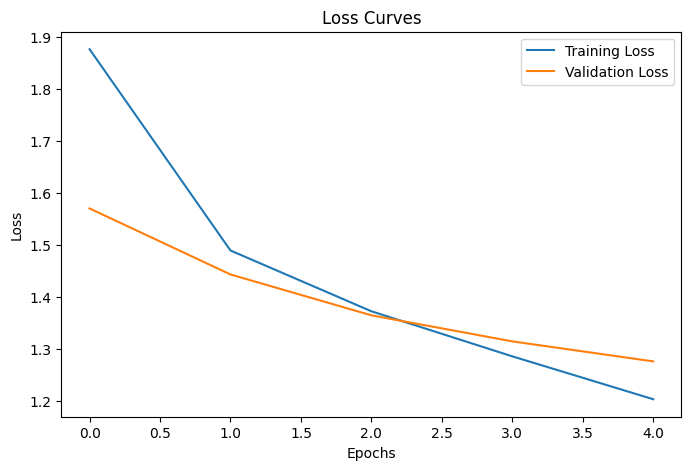

<Figure size 640x480 with 0 Axes>

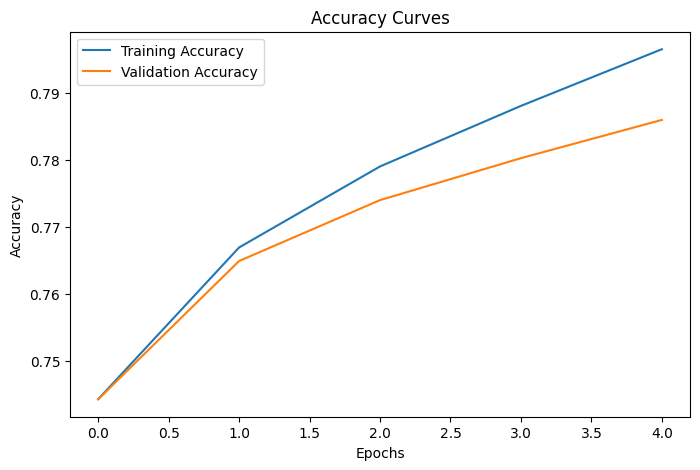

<Figure size 640x480 with 0 Axes>

In [181]:
def plot_individual_curves(history):
    # Loss plot
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.savefig('loss_curves.png')

    # Accuracy plot
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    plt.savefig('accuracy_curves.png')

plot_individual_curves(history)